In [ ]:
import numpy as np
import pandas as pd
import emoji
from bs4 import BeautifulSoup
import os
import re
import string
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('train.csv')

# Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Class Weights Visualization

<ipython-input-4-089146dca7ff>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaaster (3271)'])


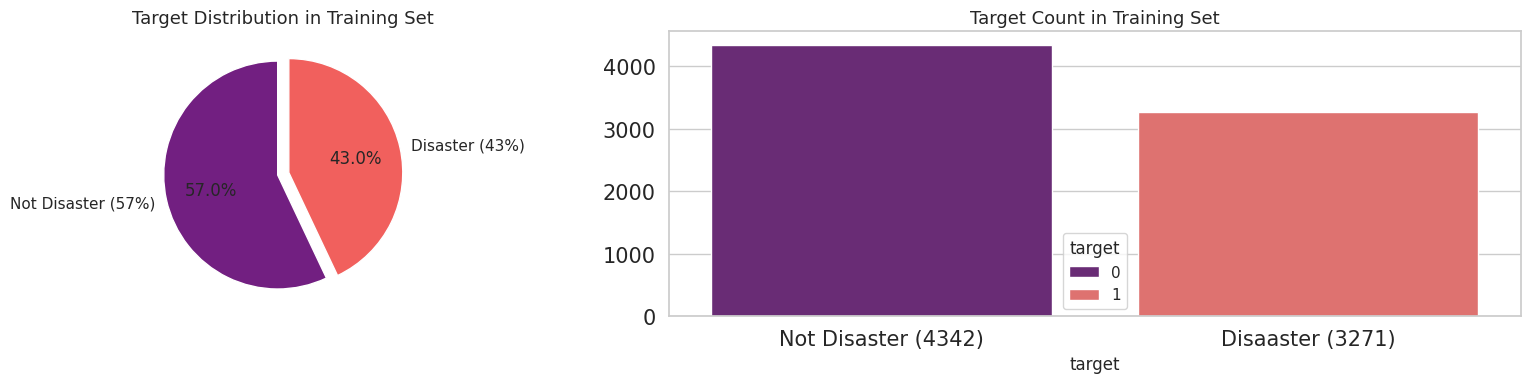

In [ ]:
sns.set(style='whitegrid', palette='magma')
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df.groupby('target').count()['id'].plot(
    kind='pie',
    ax=axes[0],
    labels=['Not Disaster (57%)', 'Disaster (43%)'],
    colors=sns.color_palette('magma', 2),
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.05, 0.05)
)

sns.countplot(x=df['target'], hue=df['target'], ax=axes[1], palette='magma')

axes[0].set_ylabel('')
axes[1].set_ylabel('')

axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaaster (3271)'])

axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.tight_layout()

plt.show()

In [ ]:
df_mislabeled = df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']

mislabeled_texts = df_mislabeled.index.tolist()
mislabeled_indices = df[df['text'].isin(mislabeled_texts)].index

print("Mislabeled Texts and Their Indices:")
for idx in mislabeled_indices:
    print(f"Index: {idx}, Text: {df.loc[idx, 'text']}, Original Label: {df.loc[idx, 'target']}")

Mislabeled Texts and Their Indices:
Index: 610, Text: To fight bioterrorism sir., Original Label: 1
Index: 624, Text: To fight bioterrorism sir., Original Label: 0
Index: 630, Text: To fight bioterrorism sir., Original Label: 1
Index: 634, Text: To fight bioterrorism sir., Original Label: 0
Index: 1197, Text: Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh..., Original Label: 1
Index: 1214, Text: I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????, Original Label: 0
Index: 1221, Text: like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit, Original Label: 1
Index: 1331, Text: Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh..., Original Label: 0
Index: 1349, Text: like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit, Original Label: 0
Index: 1365, 


## Contraction Mapping and corrections

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-',
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [ ]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''
    #Removes awkward spaces
    text = text.strip()
    text = text.split()
    return " ".join(text)

In [ ]:
def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_contractions(text, contraction_mapping)
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = remove_space(text)
    return text

In [ ]:
df['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [ ]:
df['text'] = df['text'].astype(str)

In [ ]:
df['text'] = df['text'].apply(lambda x: text_preprocessing_pipeline(x))

In [ ]:
df['text']

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       people receive wildfires evacuation orders in ...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610                                  s of volcano hawaii
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [ ]:
df['disaster'] = df['target'].apply(lambda x: 1 if x == 1 else 0)
df['not_disaster'] = df['target'].apply(lambda x: 0 if x == 1 else 1)

In [ ]:
df.drop(columns=['id', 'keyword', 'location', 'target'], inplace=True)

In [ ]:
max_len = df['text'].apply(len).max()
max_len

145

## Split Training Set and Test Set

In [ ]:
def test_train_split(dataset, test_ratio=0.1):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [ ]:
train_ds_pd, validation_ds_pd = test_train_split(df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(validation_ds_pd)))

6851 examples in training, 762 examples in testing.


In [ ]:
train_ds_pd = train_ds_pd.reset_index(drop=True)
validation_ds_pd = validation_ds_pd.reset_index(drop=True)

In [ ]:
import torch
import torch.nn
import torch.nn as nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
from transformers import DebertaV2Model, DebertaV2Tokenizer
from torch.utils.data import Dataset, DataLoader

In [ ]:
tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base')

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# PyTorch, Ray, Optuna

In [ ]:
from torch.optim import AdamW
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
import optuna
from ray import tune
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.schedulers import ASHAScheduler
from torch.amp import GradScaler, autocast
from ray.tune.search.optuna import OptunaSearch
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from torch import autocast
from ray.tune.logger import TBXLogger
from torch.utils.tensorboard import SummaryWriter
from ray.train import report
from ray.tune import JupyterNotebookReporter
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from ray.tune.schedulers import HyperBandScheduler, AsyncHyperBandScheduler

2024-08-31 07:48:16,952	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-31 07:48:17,445	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# DATASET AND ENCODING

In [ ]:
class DisasterDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index]['text'])
        labels = self.data.iloc[index][['disaster', 'not_disaster']].values.astype(np.float32)

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False
        )

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# MODEL DEFINITION

In [ ]:
class DisasterModel(nn.Module):
    def __init__(self, roberta_model, n_classes, dropout_rate):
        super(DisasterModel, self).__init__()
        self.roberta = roberta_model
        self.drop = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(self.roberta.config.hidden_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.out = nn.Linear(256, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the [CLS] token representation (first token in the sequence)
        cls_token_state = output.last_hidden_state[:, 0, :]
        output = self.drop(cls_token_state)
        output = self.relu(self.fc1(output))
        output = self.drop(output)
        output = self.relu(self.fc2(output))
        return self.out(output)

## Custom metric calculation function

In [ ]:

def calculate_custom_metric(avg_val_loss, val_accuracy, avg_train_loss, train_accuracy, alpha=0.5, beta=0.5):
    loss_diff = abs(avg_train_loss - avg_val_loss)
    accuracy_diff = abs(train_accuracy - val_accuracy)
    custom_metric = avg_val_loss - val_accuracy + alpha * loss_diff + beta * accuracy_diff
    return custom_metric

## Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        EarlyStopping to stop training when a metric has stopped improving.

        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

## Define the training function with variable parameters

In [ ]:

def train_model(config, train_dataset, val_dataset, device):
    model = DisasterModel(
        roberta_model=DebertaV2Model.from_pretrained('microsoft/deberta-v3-base'),
        n_classes=2,
        dropout_rate=config["dropout_rate"]
    )
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    criterion = nn.BCEWithLogitsLoss()
    scaler = GradScaler()

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    early_stopping = EarlyStopping(patience=3, verbose=True)

    for epoch in range(config["epochs"]):
        model.train()
        total_train_loss = 0.0
        correct_train_preds = 0
        total_train_preds = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()

            with autocast(device_type=device.type):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

            probabilities = torch.sigmoid(outputs)
            predictions = torch.zeros_like(probabilities)
            max_indices = torch.argmax(probabilities, dim=1)
            predictions.scatter_(1, max_indices.unsqueeze(1), 1)
            predictions = predictions.float()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


            total_train_loss += loss.item()
            correct_train_preds += (predictions == labels).sum().item()
            total_train_preds += labels.numel()

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train_preds / total_train_preds

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        correct_val_preds = 0
        total_val_preds = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                with autocast(device_type=device.type):
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs, labels)

                probabilities = torch.sigmoid(outputs)
                predictions = torch.zeros_like(probabilities)
                max_indices = torch.argmax(probabilities, dim=1)
                predictions.scatter_(1, max_indices.unsqueeze(1), 1)
                predictions = predictions.float()


                total_val_loss += loss.item()

                correct_val_preds += (predictions == labels).sum().item()
                total_val_preds += labels.numel()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val_preds / total_val_preds
        custom_metric = calculate_custom_metric(avg_val_loss, val_accuracy, avg_train_loss, train_accuracy)

        # Report metrics using ray.train.report
        report({
            "loss": avg_val_loss,
            "accuracy": val_accuracy,
            "train_loss": avg_train_loss,
            "train_accuracy": train_accuracy,
            "custom_metric": custom_metric,
            "early_stopping_epoch": epoch + 1,
        })

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Check for early stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            break

    return model

def train_fn(config):
    print(f"""
    Tuning Model with:
    {config}
    """)
    tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base')

    train_dataset = DisasterDataset(train_ds_pd, tokenizer, max_len=192)
    val_dataset = DisasterDataset(validation_ds_pd, tokenizer, max_len=192)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_model(config, train_dataset, val_dataset, device)

## Optuna Study

In [ ]:
search_space = {
    'dropout_rate': tune.choice([0.2, 0.25, 0.27, 0.3, 0.35, 0.4]),
    'batch_size': tune.choice([16, 32]),
    'weight_decay': tune.choice([1e-6, 2e-6, 1e-5, 2e-5, 1e-4, 2e-4, 5e-5, 5e-6, 1e-2, 1e-3]),
    'lr': tune.choice([1e-6, 1e-5, 2e-5, 1e-4, 2e-4, 2e-6, 3e-6, 5e-6, 3e-5, 5e-5, 2e-7, 1e-7, 5e-7, 1e-3]),
    'epochs': tune.choice([5, 7, 10, 12, 15, 20])
}

In [ ]:
optuna_search = OptunaSearch(
    metric=["accuracy","custom_metric"],
    mode=["max","min"]
)

## ASHAS

In [ ]:
scheduler = ASHAScheduler(
    metric='accuracy',
    mode='max',
    max_t=22,
    grace_period=3,
    reduction_factor=2
)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Reporter

In [ ]:
reporter = JupyterNotebookReporter(
    metric_columns=["loss", "accuracy", "custom_metric", "training_iteration", "train_loss", "train_accuracy", "early_stopping_epoch"],
    print_intermediate_tables=False,
)


result = tune.run(
    train_fn,
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=search_space,
    num_samples=30,
    scheduler=scheduler,
    progress_reporter=reporter,
    search_alg=optuna_search
)

2024-08-31 07:48:34,476	INFO worker.py:1753 -- Started a local Ray instance.
2024-08-31 07:48:35,711	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-08-31 07:48:35,718	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2024-08-31 07:48:35,782] A new study created in memory with name: optuna
(train_fn pid=342) /opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
(train_fn pid=342)   warnings.warn(
(t

Trial name,accuracy,custom_metric,early_stopping_epoch,loss,train_accuracy,train_loss
train_fn_0274839b,0.581365,0.0299554,6,0.590231,0.57539,0.626435
train_fn_04c201a4,0.82021,-0.120021,6,0.538408,0.898409,0.293046
train_fn_1001a77b,0.822835,-0.107876,5,0.521743,0.919866,0.232344
train_fn_159fadbe,0.82021,-0.10957,6,0.518328,0.91899,0.232484
train_fn_1adb15d9,0.824147,-0.352332,6,0.449641,0.835207,0.482929
train_fn_1b3cce40,0.817585,-0.373208,3,0.429158,0.832433,0.444749
train_fn_1d27ca86,0.817585,-0.207232,9,0.473453,0.901766,0.283832
train_fn_1df2f428,0.581365,0.0987595,3,0.669038,0.569406,0.679251
train_fn_3476e9ff,0.581365,0.0857604,3,0.650594,0.571449,0.673741
train_fn_376ed20c,0.804462,-0.166841,6,0.553958,0.660633,0.577456


(train_fn pid=522) /opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
(train_fn pid=522)   warnings.warn(
(train_fn pid=642) /opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
(train_fn pid=642)   warnings.warn(
(train_fn pid=757) /opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_s

# Results

In [ ]:
best_trial = result.get_best_trial("accuracy", "max", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")
print(f"Best trial final training loss: {best_trial.last_result['train_loss']}")
print(f"Best trial final training accuracy: {best_trial.last_result['train_accuracy']}")
print(f"Best trial final custom_metric: {best_trial.last_result['custom_metric']}")
print(f"Best trial final Early Stopping Epoch: {best_trial.last_result['early_stopping_epoch']}")
print(f"NOTE: Both the accuracy are based on converting values > 0.5 to 1 and values < 0.5 to 0, hence, rely on the loss, MSE here.")

Best trial config: {'dropout_rate': 0.35, 'batch_size': 32, 'weight_decay': 5e-05, 'lr': 5e-07, 'epochs': 15}
Best trial final validation loss: 0.4034118702014287
Best trial final validation accuracy: 0.847769028871391
Best trial final training loss: 0.39758711131506186
Best trial final training accuracy: 0.8578309735804992
Best trial final custom_metric: -0.43641380687222486
Best trial final Early Stopping Epoch: 15
NOTE: Both the accuracy are based on converting values > 0.5 to 1 and values < 0.5 to 0, hence, rely on the loss, MSE here.


## Function to Train the Model with the Best Configuration

In [ ]:
def train_best_model(config, device, train_dataset = train_ds_pd, val_dataset = validation_ds_pd):

    print(f"""
    Tuning Model with:
    {config}
    """)

    model = DisasterModel(
        roberta_model=DebertaV2Model.from_pretrained('microsoft/deberta-v3-base'),
        n_classes=2,
        dropout_rate=config["dropout_rate"]
    )
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    criterion = nn.BCEWithLogitsLoss()
    scaler = GradScaler()

    ## DATASET ENCODING

    train_dataset = DisasterDataset(train_ds_pd, tokenizer, max_len=192)
    val_dataset = DisasterDataset(validation_ds_pd, tokenizer, max_len=192)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    early_stopping = EarlyStopping(patience=5, verbose=True)

    best_val_loss = float("inf")
    best_model_path = None

    # Early stopping parameters
    patience = 5
    best_val_loss = float('inf')
    epochs_since_improvement = 0


    ### Running for config epochs +patience+1 for introducing noise.

    for epoch in range((config["epochs"]+patience+1)):
        model.train()
        total_train_loss = 0.0
        correct_train_preds = 0
        total_train_preds = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()

            with autocast(device_type=device.type):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

                probabilities = torch.sigmoid(outputs)
                predictions = torch.zeros_like(probabilities)
                max_indices = torch.argmax(probabilities, dim=1)
                predictions.scatter_(1, max_indices.unsqueeze(1), 1)
                predictions = predictions.float()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


            total_train_loss += loss.item()

            correct_train_preds += (predictions == labels).sum().item()
            total_train_preds += labels.numel()

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train_preds / total_train_preds

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        correct_val_preds = 0
        total_val_preds = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                with autocast(device_type=device.type):
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs, labels)

                probabilities = torch.sigmoid(outputs)
                predictions = torch.zeros_like(probabilities)
                max_indices = torch.argmax(probabilities, dim=1)
                predictions.scatter_(1, max_indices.unsqueeze(1), 1)
                predictions = predictions.float()

                total_val_loss += loss.item()

                correct_val_preds += (predictions == labels).sum().item()
                total_val_preds += labels.numel()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val_preds / total_val_preds

        # Save the model checkpoint after each epoch
        checkpoint_path = f"./best_checkpoint.pt"

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_since_improvement = 0
            best_model_path = checkpoint_path
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': config
            }, checkpoint_path)

        else:
            epochs_since_improvement += 1

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            print(f"Best Model Epoch Saved: {epoch - patience+1}")
            print("Early stopping")
            break
        custom_metric = calculate_custom_metric(avg_val_loss, val_accuracy, avg_train_loss, train_accuracy)
        print(f"""
        Validation Loss: {avg_val_loss},
        Training Loss: {avg_train_loss},
        Argmax Binary Validation Accuracy: {val_accuracy},
        Argmax Binary Training Accuracy: {train_accuracy},
        Custom Metric: {custom_metric},
        Epochs: {epoch+1}
        """)

    print(f"Best Validation Loss: {best_val_loss}, Best Validation accuracy: {val_accuracy}")

    return model, best_model_path

# Best Model

In [ ]:
best_config = best_trial.config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model with the best configuration
best_model, best_model_path = train_best_model(best_config, device, train_ds_pd, validation_ds_pd)


    Tuning Model with:
    {'dropout_rate': 0.35, 'batch_size': 32, 'weight_decay': 5e-05, 'lr': 5e-07, 'epochs': 15}
    

        Validation Loss: 0.6908719589312872,
        Training Loss: 0.6916125450023385,
        Argmax Binary Validation Accuracy: 0.5813648293963255,
        Argmax Binary Training Accuracy: 0.5286819442417166,
        Custom Metric: 0.1362188651477918,
        Epochs: 1
        

        Validation Loss: 0.6837895313898722,
        Training Loss: 0.6873823030050411,
        Argmax Binary Validation Accuracy: 0.5813648293963255,
        Argmax Binary Training Accuracy: 0.5603561523865129,
        Custom Metric: 0.11472542630603744,
        Epochs: 2
        

        Validation Loss: 0.6639296337962151,
        Training Loss: 0.6777441146761872,
        Argmax Binary Validation Accuracy: 0.5813648293963255,
        Argmax Binary Training Accuracy: 0.5784556998978251,
        Custom Metric: 0.09092660958912585,
        Epochs: 3
        

        Validation Loss:

## Save the best model

In [ ]:


final_model_path = "./final_best_model.pt"
torch.save({'model_state_dict': best_model.state_dict(),'config': best_config}, final_model_path)

print(f"Best model saved at: {final_model_path}")

## Load the best model

In [ ]:
# Load the best model
final_model_path = "./final_best_model.pt"

checkpoint = torch.load(final_model_path)
config = checkpoint['config']

loaded_model = DisasterModel(
    roberta_model=DebertaV2Model.from_pretrained('microsoft/deberta-v3-base'),
    n_classes=2,
    dropout_rate=config["dropout_rate"]
)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model = loaded_model.to(device)
loaded_model.eval()

print(f"Loaded model from {final_model_path} for inference.")

## Prediction Function

In [ ]:
def predict(text, model, tokenizer, device, max_len=192):
    inputs = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    return torch.sigmoid(outputs).cpu().numpy()

In [ ]:
best_model = loaded_model
best_model = best_model.to(device)

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px

# Test Set Prediction

In [ ]:
df_test = pd.read_csv('./test.csv')

In [ ]:
df_test['text'] =df_test['text'].astype(str)

In [ ]:
df_test['text'] = df_test['text'].apply(lambda x: text_preprocessing_pipeline(x))

In [ ]:
test_id = df_test['id']

In [ ]:
df_test.drop(columns=['id', 'keyword', 'location'], inplace=True)

In [ ]:
predictions_final = []

for text in df_test['text']:
    predictions = predict(text, best_model, tokenizer, device)

    predictions_array = predictions.squeeze()
    binary_predictions = np.zeros_like(predictions_array)
    max_indices = np.argmax(predictions_array)
    binary_predictions[max_indices] = 1
    final_label = 1 if binary_predictions[0] == 1 else 0

    predictions_final.append(final_label)

## Submission

In [ ]:
submission_df = pd.read_csv('./deploy_sheet.csv')
submission_df['target'] = predictions_final

In [ ]:
submission_df.to_csv('./submission.csv', index=False)